Random number matrix loaded correctly: 1000 simulations × 36 months

Initial prices (t=0): {'A': np.float64(99.26337488412562), 'B': np.float64(95.83404944526177), 'C': np.float64(112.6591588226511)}

===== Q1(b): 3-year total return summary across 1,000 paths =====
       Mean    Median       Std        P5       P10       P25       P75  \
A  0.143603  0.143624  0.006526  0.133035  0.135592  0.139120  0.147929   
B  0.143069  0.143058  0.000609  0.142080  0.142322  0.142651  0.143461   
C  0.142617  0.142442  0.006184  0.132430  0.134927  0.138602  0.146750   

        P90       P95  
A  0.151889  0.154605  
B  0.143833  0.144066  
C  0.150416  0.152966  


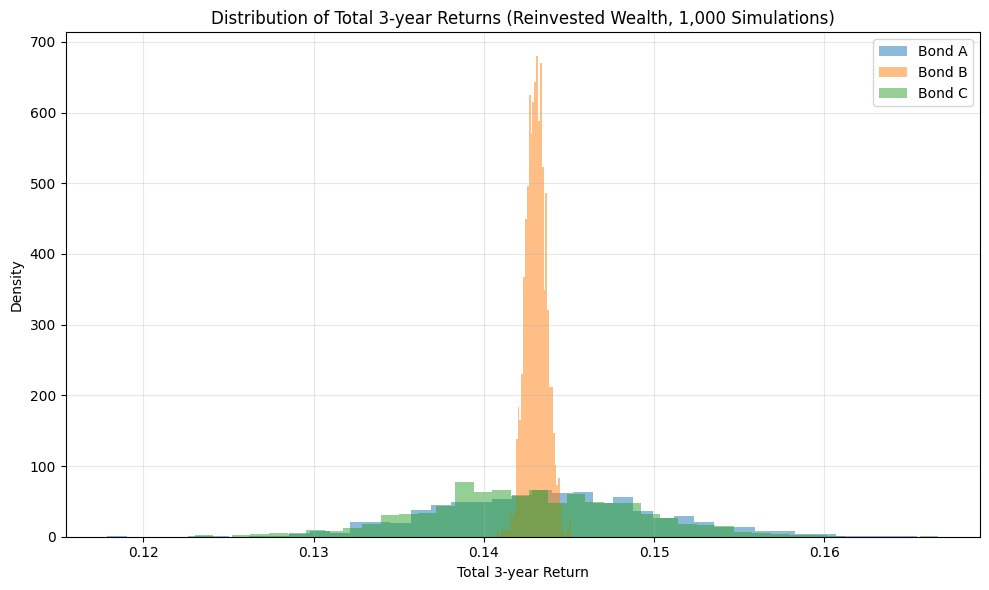

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1. Load random numbers (1000 × 36)
# ---------------------------------------------------
file_path = "Normally distributed random numbers.xlsx"
z = pd.read_excel(file_path, header=0, index_col=0).to_numpy(dtype=float)
n_sim, n_months = z.shape
print(f"Random number matrix loaded correctly: {n_sim} simulations × {n_months} months")

# ---------------------------------------------------
# 2. Vasicek parameters
# ---------------------------------------------------
a = 0.46
b = 0.05
sigma = 0.006
r0 = 0.04
dt = 1 / 12  # monthly step (1 month = 1/12 year)

# ---------------------------------------------------
# 3. Simulate short rate paths
# ---------------------------------------------------
r = np.zeros((n_sim, n_months + 1))
r[:, 0] = r0
for t in range(n_months):
    dr = a * (b - r[:, t]) * dt + sigma * np.sqrt(dt) * z[:, t]
    r[:, t + 1] = r[:, t] + dr

# ---------------------------------------------------
# 4. Vasicek zero rate functions
# ---------------------------------------------------
def B_func(a, tau):
    return (1 - np.exp(-a * tau)) / a

def A_func(a, b, sigma, tau):
    B = B_func(a, tau)
    term1 = (B - tau) * (a**2 * b - sigma**2 / 2) / (a**2)
    term2 = (sigma**2 * B**2) / (4 * a)
    return term1 - term2

def zero_rate(a, b, sigma, r_t, tau):
    B = B_func(a, tau)
    A = A_func(a, b, sigma, tau)
    return (B * r_t - A) / tau

# ---------------------------------------------------
# 5. Bond setup
# ---------------------------------------------------
bonds = {
    "A": {"coupon": 0.04, "maturity": 2},
    "B": {"coupon": 0.03, "maturity": 3},
    "C": {"coupon": 0.075, "maturity": 5},
}
coupon_freq = 2   # semiannual
horizon = 3       # investment horizon (years)

# ---------------------------------------------------
# 6. Bond pricing at t=0
# ---------------------------------------------------
def price_bond(a, b, sigma, r_t, bond):
    """Price a bond using Vasicek zero curve at t=0."""
    c = bond["coupon"]
    T = bond["maturity"]
    n_pay = int(T * coupon_freq)
    times = np.arange(1, n_pay + 1) / coupon_freq
    cfs = np.full(n_pay, c / coupon_freq * 100)
    cfs[-1] += 100
    R = np.array([zero_rate(a, b, sigma, r_t, tau) for tau in times])
    discount = np.exp(-R * times)
    return np.sum(cfs * discount)

P0 = {k: price_bond(a, b, sigma, r0, v) for k, v in bonds.items()}
print("\nInitial prices (t=0):", P0)

# ---------------------------------------------------
# 7. Simulate total 3-year returns (reinvested wealth)
# ---------------------------------------------------
results = {k: np.zeros(n_sim) for k in bonds}

for i in range(n_sim):
    # Simulated short-rate path for one scenario (r[1..36])
    r_path = r[i, 1:]
    month_growth = np.exp(r_path * dt)   # continuous monthly growth factors

    for name, bond in bonds.items():
        c = bond["coupon"]
        T = bond["maturity"]
        pay_months = (np.arange(1, int(T * coupon_freq) + 1) / coupon_freq * 12).astype(int)
        P0_bond = P0[name]
        wealth = 0.0  # reinvested coupon account

        for month in range(1, int(horizon * 12) + 1):
            # 1) compound existing wealth for this month
            wealth *= month_growth[month - 1]

            # 2) if coupon arrives, add it at month-end
            if month in pay_months:
                if month < T * 12:
                    wealth += c / coupon_freq * 100
                elif month == T * 12:
                    wealth += 100 + c / coupon_freq * 100

        # 3) if bond not matured by horizon, compute sale price
        sell_price = 0.0
        if T * 12 > horizon * 12:
            r_T = r_path[-1]  # short rate at horizon (t=3yr)
            remaining = pay_months[pay_months > horizon * 12]
            for m in remaining:
                tau = (m - horizon * 12) / 12  # years to payment after horizon
                cf = c / coupon_freq * 100
                if m == T * 12:
                    cf += 100
                R = zero_rate(a, b, sigma, r_T, tau)
                DF = np.exp(-R * tau)
                sell_price += cf * DF

        # 4) total wealth and total return
        total_wealth = wealth + sell_price
        results[name][i] = total_wealth / P0_bond - 1

# ---------------------------------------------------
# 8. Summary statistics
# ---------------------------------------------------
summary, percentiles = {}, [5, 10, 25, 75, 90, 95]
for k, v in results.items():
    summary[k] = {
        "Mean": np.mean(v),
        "Median": np.median(v),
        "Std": np.std(v, ddof=1),
        **{f"P{p}": np.percentile(v, p) for p in percentiles},
    }

df_summary = pd.DataFrame(summary).T.round(6)
print("\n===== Q1(b): 3-year total return summary across 1,000 paths =====")
print(df_summary)

# ---------------------------------------------------
# 9. Plot distributions
# ---------------------------------------------------
plt.figure(figsize=(10, 6))
for k, v in results.items():
    plt.hist(v, bins=40, density=True, alpha=0.5, label=f"Bond {k}")
plt.xlabel("Total 3-year Return")
plt.ylabel("Density")
plt.title("Distribution of Total 3-year Returns (Reinvested Wealth, 1,000 Simulations)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


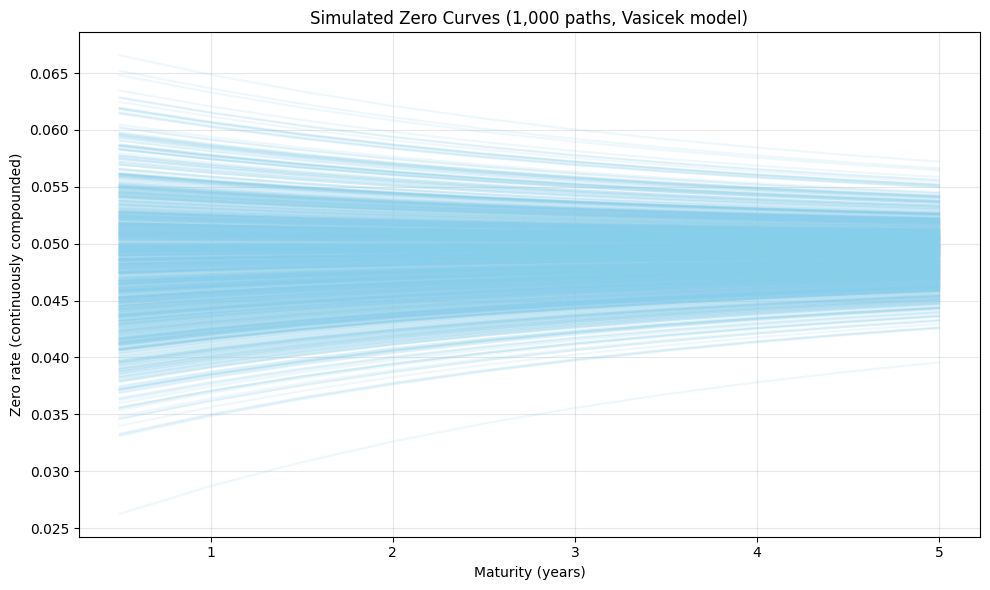

In [5]:
# ---------------------------------------------------
# 3b. Plot 1,000 simulated zero curves (using Vasicek paths)
# ---------------------------------------------------
taus = np.linspace(0.5, 5, 10)  # maturities from 0.5 to 5 years
zero_curves = np.zeros((n_sim, len(taus)))

for i in range(n_sim):
    r_t = r[i, -1]  # use short rate at final month (t = 3 years)
    zero_curves[i, :] = [zero_rate(a, b, sigma, r_t, tau) for tau in taus]

plt.figure(figsize=(10, 6))
for i in range(n_sim):
    plt.plot(taus, zero_curves[i, :], color='skyblue', alpha=0.15)
plt.title("Simulated Zero Curves (1,000 paths, Vasicek model)")
plt.xlabel("Maturity (years)")
plt.ylabel("Zero rate (continuously compounded)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
